**UNIVERSIDAD DE ANTIOQUIA - ESPECIALIZACIÓN EN ANALÍTICA Y CIENCIA DE DATOS**

**ENTREGA PRIMERA ITERACIÓN - SEMINARIO**

**Juan David García Álvarez** 

**CC. 1214740056**

**PROYECTO: CRYPTO FORECASTING**

Enlace compentecia de Kaggle:  https://www.kaggle.com/c/g-research-crypto-forecasting

Referencias: 
- https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition/notebook
- https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1


# **01. IMPORTACIÓN DE LIBRERÍAS**




In [1]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
#from google.colab import files
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error


# **02. CARGA Y LECTURA DE DATOS**




Se procede con la lectura de los diferentes archivos que se usarán para el desarrollo del proyecto:

In [3]:
data = pd.read_csv('../train.csv')           # Archivo que contiene el dataset del proyecto

In [4]:
asset_details = pd.read_csv('../asset_details.csv')  # Archivo con la información del nombre real de la criptomoneda junto con su ID
                                                  # Contiene también el "Peso" que cada criptomoneda recibe en la metrica.

In [5]:
example_test = pd.read_csv('../example_test.csv')            # Archivos con ejemplos de los datos que se emplearán para el test (Relacionado con la competencia de Kaggle)
example_sample_submission = pd.read_csv('../example_sample_submission.csv')      

# **03. ANÁLISIS Y EXPLORACIÓN DE LOS DATOS**




##Exploración inicial del dataset

Este conjunto de datos contiene la información sobre el historico de transacciones para varias criptomonedas. Cada fila del dataset corresponde a los datos del mercado para cada criptomoneda en un intervalo de tiempo de un minuto. El objetivo del proyecto es predecir el rendimiento futuro que tendrá cada criptomoneda.

La primera columna contiene el índice de tiempo donde fueron tomados los datos, la segunda identifica la criptomoneda correspondiente, las siguientes 6 columnas son los datos comerciales que tuvo la moneda en ese minuto y la última columna es el objetivo de predicción.


**Características de los datos:**

- **Timestamp:** Indicador del minuto cubierto por cada fila (en formato de tiempo Unix). Cada registro es múltiplo de 60, dado que corresponde a los datos tomados minuto a minuto

- **Asset_ID:** Código de identificación de la criptomoneda

- **Count:** Número de intercambios que se realizaron en el minuto

- **Open:** Precio de la criptomoneda al comienzo del minuto (USD)

- **High:** Precio más alto de la criptomoneda durante el minuto (USD)

- **Low:** Precio más bajo de la criptomoneda durante el minuto (USD)

- **Close:** Precio de la criptomoneda finalizar el minuto (USD)

- **Volume:** Cantidad de criptomonedas negociadas durante el minuto 

- **VWAP:** Precio medio del activo durante el minuto, ponderado por el volumen

- **Target:** Rentabilidad logarítmica de la criptomoneda en un horizonte de 15 minutos

In [106]:
data

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [8]:
asset_details  # Se presentan las criptomonedas con su respectivo ID y peso asignado en el problema para el calculo de la variable "Target" 

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [105]:
display(data.shape) # Tamaño del dataset

(24236806, 10)

In [107]:
display(data.isnull().sum())  # Verificamos si hay datos nulos o faltantes

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [11]:
nan_rows = data[data.isnull().any(1)]

In [12]:
nan_rows # filas target con valores nulos

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
7,1514764860,11,7.0,329.090000,329.880000,329.090000,329.460000,6.635710e+00,329.454118,NaN
44,1514765160,7,76.0,26.425500,27.073000,25.550000,26.400000,1.857937e+03,26.352542,NaN
95,1514765520,11,8.0,327.670000,327.680000,326.770000,326.770000,1.790163e+01,326.990493,NaN
111,1514765640,11,8.0,326.930000,327.960000,326.220000,327.910000,2.684030e+01,326.476237,NaN
116,1514765700,7,12.0,26.441000,27.070000,25.812000,26.399000,1.638301e+02,26.449597,NaN
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


In [13]:
nan_vwap = nan_rows[nan_rows['VWAP'].isnull()]

In [14]:
nan_vwap # filas vwap con valores nulos

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
15004269,1592173560,10,2.0,501.00,501.00,501.00,501.00,0.0,NaN,NaN
15004283,1592173620,10,4.0,501.00,501.00,501.00,501.00,0.0,NaN,NaN
15059232,1592426160,10,2.0,529.77,529.77,529.77,529.77,0.0,NaN,0.007356
15143187,1592823720,10,2.0,503.60,503.60,503.60,503.60,0.0,NaN,-0.005672
15183088,1593008940,10,2.0,484.16,484.16,484.16,484.16,0.0,NaN,-0.004281
15184216,1593013920,10,2.0,480.00,480.00,480.00,480.00,0.0,NaN,NaN
15184243,1593014040,10,2.0,480.00,480.00,480.00,480.00,0.0,NaN,NaN
15184309,1593014340,10,6.0,479.07,479.07,479.07,479.07,0.0,NaN,NaN
15184778,1593016440,10,4.0,478.00,478.00,475.00,478.00,0.0,NaN,NaN


In [15]:
nan_target = nan_rows[nan_rows['Target'].isnull()]

In [16]:
nan_target

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
7,1514764860,11,7.0,329.090000,329.880000,329.090000,329.460000,6.635710e+00,329.454118,NaN
44,1514765160,7,76.0,26.425500,27.073000,25.550000,26.400000,1.857937e+03,26.352542,NaN
95,1514765520,11,8.0,327.670000,327.680000,326.770000,326.770000,1.790163e+01,326.990493,NaN
111,1514765640,11,8.0,326.930000,327.960000,326.220000,327.910000,2.684030e+01,326.476237,NaN
116,1514765700,7,12.0,26.441000,27.070000,25.812000,26.399000,1.638301e+02,26.449597,NaN
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


In [17]:
criptos = []
num_nan = {}
for id, name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
    moneda = nan_target[nan_target["Asset_ID"]==id].set_index("timestamp")
    criptos.append(moneda)
    num_nan[name] = moneda['Target'].isnull().sum()

In [112]:
pd.DataFrame(num_nan.items(), columns=['Criptomoneda', 'Cantidad Nulos'])

,Criptomoneda,Cantidad Nulos
0,Bitcoin Cash,4861
1,Binance Coin,13415
2,Bitcoin,304
3,EOS.IO,2302
4,Ethereum Classic,9326
5,Ethereum,340
6,Litecoin,521
7,Monero,239603
8,TRON,21014
9,Stellar,61816


In [19]:
btc = criptos[2]

In [20]:
btc

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1571201700,1,15.0,8164.253333,8169.970000,8163.92,8165.283333,0.473769,8165.547106,NaN
1571201820,1,9.0,8167.122500,8169.770000,8165.01,8166.142500,0.622516,8167.036652,NaN
1571201940,1,22.0,8164.242500,8165.080000,8162.90,8163.950000,0.671666,8164.156317,NaN
1571202000,1,6.0,8164.370000,8166.000000,8159.41,8161.535000,0.593204,8164.801750,NaN
1571202060,1,6.0,8165.580000,8165.810000,8165.26,8165.260000,0.218742,8165.510211,NaN
...,...,...,...,...,...,...,...,...,...
1632182160,1,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913,42935.489499,NaN
1632182220,1,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326,42879.576084,NaN
1632182280,1,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734,42844.090693,NaN


In [21]:
for i in range(len(btc.index)):
    fecha_btc_nan = btc.index[i]
    fecha_btc_nan = datetime.utcfromtimestamp(fecha_btc_nan).strftime('%Y-%m-%d %H:%M:%S')
    print('Fecha:  ', fecha_btc_nan)

Fecha:   2019-10-16 04:55:00
Fecha:   2019-10-16 04:57:00
Fecha:   2019-10-16 04:59:00
Fecha:   2019-10-16 05:00:00
Fecha:   2019-10-16 05:01:00
Fecha:   2019-10-16 05:02:00
Fecha:   2019-10-16 05:03:00
Fecha:   2019-10-16 05:04:00
Fecha:   2019-10-16 05:05:00
Fecha:   2019-10-16 05:06:00
Fecha:   2019-10-16 05:07:00
Fecha:   2019-10-16 05:08:00
Fecha:   2019-10-16 05:09:00
Fecha:   2019-10-16 05:10:00
Fecha:   2019-10-16 05:12:00
Fecha:   2019-10-16 05:16:00
Fecha:   2019-10-16 05:56:00
Fecha:   2019-10-16 06:00:00
Fecha:   2019-10-16 06:01:00
Fecha:   2019-10-16 06:02:00
Fecha:   2019-10-16 06:04:00
Fecha:   2019-10-16 06:06:00
Fecha:   2019-10-16 06:07:00
Fecha:   2019-10-16 06:09:00
Fecha:   2019-10-16 06:10:00
Fecha:   2019-10-16 06:11:00
Fecha:   2019-10-16 06:29:00
Fecha:   2019-10-16 06:36:00
Fecha:   2019-10-16 06:43:00
Fecha:   2019-10-16 07:00:00
Fecha:   2019-10-16 07:11:00
Fecha:   2019-10-16 07:20:00
Fecha:   2019-10-16 07:24:00
Fecha:   2019-10-16 07:32:00
Fecha:   2019-

In [22]:
data_zero = data[data['Close'] <= 0]
data_zero

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target


In [23]:
#1571201700
#1571201760
#1571202660

In [24]:
prueba = data[data['timestamp'] == 1571202660]
prueba

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
10658961,1571202660,4,1.0,0.002525,0.002525,0.002525,0.002525,86464.0,0.002525,NaN
10658962,1571202660,12,1.0,0.063771,0.063771,0.063771,0.063771,140.0,0.063771,NaN


## Preprocesamiento

Inicialmente, para esta primera iteración se realizará todo el proceso solo con la criptomoneda Bitcoin. 

In [25]:
#Se selecciona la criptomoneda Bitcoin para el análisis inicial
bitcoin = data[data["Asset_ID"]==1].set_index("timestamp") 
bitcoin.shape 

(1956282, 9)

In [26]:
bitcoin.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [27]:
#Se observa el rango de tiempo para el cual la base de datos tiene registros de esta moneda
inicio_bitcoin = bitcoin.index[0].astype('datetime64[s]')
final_bitcoin = bitcoin.index[-1].astype('datetime64[s]')

print('Registros para Bitcoin desde  ', inicio_bitcoin, ' hasta  ', final_bitcoin)

Registros para Bitcoin desde   2018-01-01T00:01:00  hasta   2021-09-21T00:00:00


In [28]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956282 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Asset_ID  int64  
 1   Count     float64
 2   Open      float64
 3   High      float64
 4   Low       float64
 5   Close     float64
 6   Volume    float64
 7   VWAP      float64
 8   Target    float64
dtypes: float64(8), int64(1)
memory usage: 149.3 MB


In [29]:
bitcoin.isna().sum() # Verificamos si hay datos nulos o faltantes y la cantidad de estos

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      304
dtype: int64

In [30]:
#bitcoin = bitcoin.dropna(axis='index')

In [31]:
bitcoin.shape

(1956282, 9)

Adicionalmente, para este problema los datos faltantes durante un minuto determinado no solo están representados por NaN, sino por la ausencia de esas filas. Se puede comprobar si faltan datos realizando la diferencia de tiempo entre dos filas consecutivas.

In [32]:
(bitcoin.index[1:]-bitcoin.index[:-1]).value_counts().head()

60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

Se observa que existen vacíos en los datos ya que la diferencia entre dos filas consecutivas debería ser siempre de 60. Se procede a procesar los datos para no tener estos vacíos de tiempo.


In [33]:
def reindexar(cripto):
    return cripto.reindex(range(cripto.index[0],cripto.index[-1]+60,60),method='pad')

In [34]:
bitcoin = reindexar(bitcoin)

In [35]:
(bitcoin.index[1:]-bitcoin.index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

## Visualización de los datos

Se seleccionan los datos de Bitcoin en determinados intervalos de tiempo para ver su comportamiento mediante un **Gráfico de velas**:

In [36]:
bitcoin_part1 = bitcoin.iloc[-1440:] # Se seleccionan los datos del último día del que se tiene registro

In [37]:
inicio_bitcoin_part1 = bitcoin_part1.index[0]
inicio_bitcoin_part1 = datetime.utcfromtimestamp(inicio_bitcoin_part1).strftime('%Y-%m-%d %H:%M:%S')
final_bitcoin_part1 = bitcoin_part1.index[-1]
final_bitcoin_part1 = datetime.utcfromtimestamp(final_bitcoin_part1).strftime('%Y-%m-%d %H:%M:%S')

print('Fecha inicial:  ', inicio_bitcoin_part1, ' Fecha final:   ', final_bitcoin_part1)

Fecha inicial:   2021-09-20 00:01:00  Fecha final:    2021-09-21 00:00:00


In [38]:
plt.figure(figsize=(15,6))

fig = go.Figure(data=[go.Candlestick(x=bitcoin_part1.index,
                open=bitcoin_part1['Open'],
                high=bitcoin_part1['High'],
                low=bitcoin_part1['Low'],
                close=bitcoin_part1['Close'])])
fig.show()

<Figure size 1080x432 with 0 Axes>

In [39]:
bitcoin_part2 = bitcoin.iloc[:1440] # Se seleccionan los datos del primer día del que se tiene registro

In [40]:
inicio_bitcoin_part2 = bitcoin_part2.index[0]
inicio_bitcoin_part2 = datetime.utcfromtimestamp(inicio_bitcoin_part2).strftime('%Y-%m-%d %H:%M:%S')
final_bitcoin_part2 = bitcoin_part2.index[-1]
final_bitcoin_part2 = datetime.utcfromtimestamp(final_bitcoin_part2).strftime('%Y-%m-%d %H:%M:%S')

print('Fecha inicial:  ', inicio_bitcoin_part2, ' Fecha final:   ', final_bitcoin_part2)

Fecha inicial:   2018-01-01 00:01:00  Fecha final:    2018-01-02 00:00:00


In [41]:
plt.figure(figsize=(15,6))

fig = go.Figure(data=[go.Candlestick(x=bitcoin_part2.index,
                open=bitcoin_part2['Open'],
                high=bitcoin_part2['High'],
                low=bitcoin_part2['Low'],
                close=bitcoin_part2['Close'])])
fig.show()

<Figure size 1080x432 with 0 Axes>

Ahora se visualiza el precio (USD) con el que cerró el bitcoin cada minuto a lo largo del tiempo:

Text(0, 0.5, 'Precio - USD')

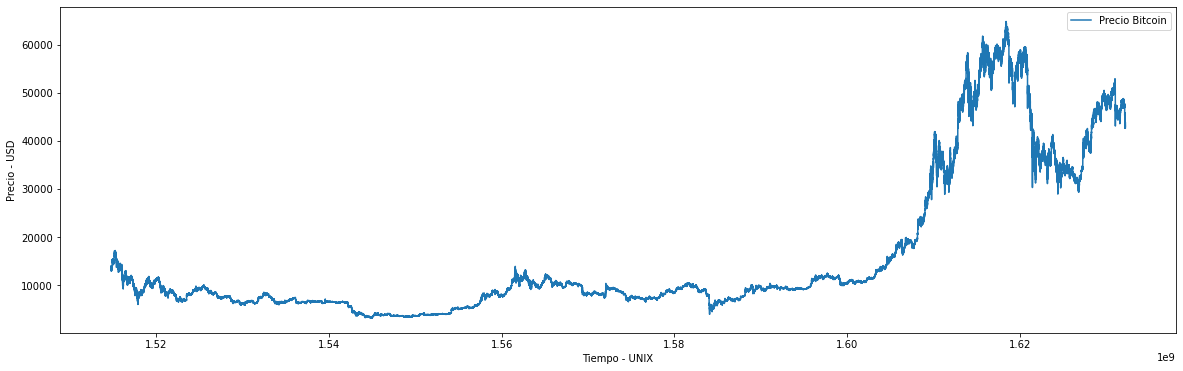

In [42]:
plt.figure(figsize=(20,6))
plt.plot(bitcoin['Close'], label='Precio Bitcoin')
plt.legend()
plt.xlabel('Tiempo - UNIX')
plt.ylabel('Precio - USD')

Se realiza el mismo ejercicio con otras criptomonedas para comprobar si existe alguna relación en el comportamiento del precio, visualmente hablando, entre ellas:

In [43]:
cardano = data[data["Asset_ID"]==3].set_index("timestamp") #Se seleccion la criptomoneda Cardano
cardano.shape

(1791867, 9)

In [44]:
doge = data[data["Asset_ID"]==4].set_index("timestamp") #Se seleccion la criptomoneda Doge Coin
doge.shape

(1156866, 9)

Text(0, 0.5, 'Precio - USD')

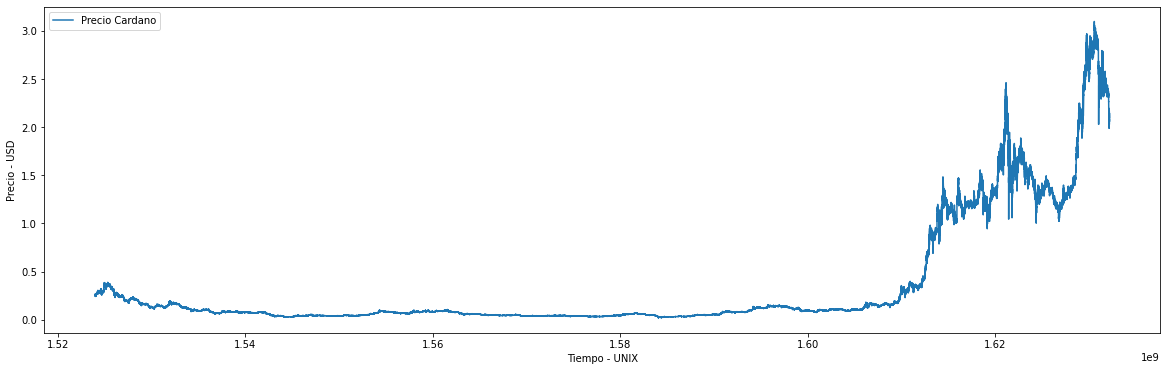

In [45]:
plt.figure(figsize=(20,6))
plt.plot(cardano['Close'], label='Precio Cardano')
plt.legend()
plt.xlabel('Tiempo - UNIX')
plt.ylabel('Precio - USD')

Text(0, 0.5, 'Precio - USD')

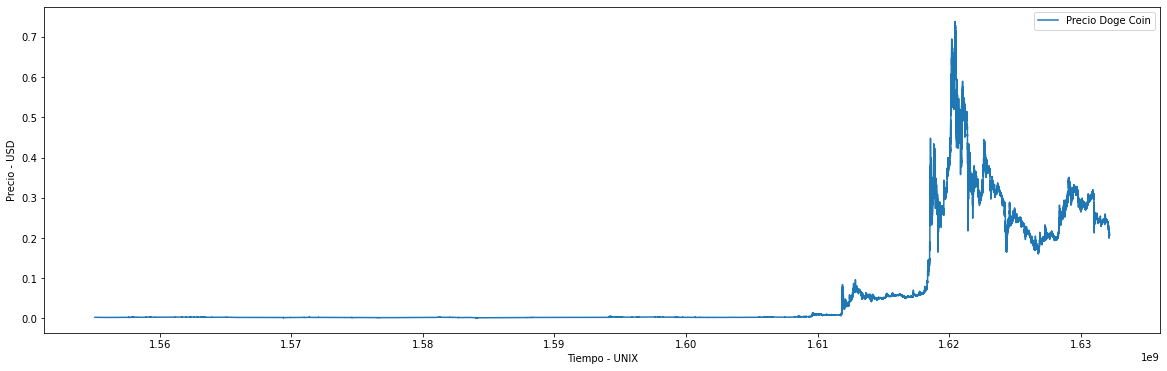

In [46]:
plt.figure(figsize=(20,6))
plt.plot(doge['Close'], label='Precio Doge Coin')
plt.legend()
plt.xlabel('Tiempo - UNIX')
plt.ylabel('Precio - USD')

Se observa que en los intervalos de tiempo más recientes podría existir correlación entre las criptomonedas Cardano y Bitcoin, mientras que Doge Coin no sigue tanto esta tendencia. 

## Correlación entre precios de criptomonedas

Una buena forma para analizar la correlación entre las criptomonedas es calcular su rendimiento logarítmico en intervalos consecutivos de tiempo.
Este rendimiento se puede calcular aplicando el logaritmo a la división entre dos precios consecutivos. 

In [47]:
def log_rendimiento(cripto):
    return np.log(cripto).diff()          # El rendimiento logarítmico se puede calcular de esta manera de acuerdo con las propiedades de los logaritmos

In [48]:
fecha_inicio = datetime(2020, 9,21, 0, 0).timestamp()   # Se define un intervalo para tomar los registros del último año
fecha_fin = datetime(2021, 9,21, 0, 0).timestamp()     # -901 

In [49]:
criptos = pd.DataFrame([])
for id, name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
  moneda = data[data["Asset_ID"]==id].set_index("timestamp")
  moneda = moneda.loc[fecha_inicio:fecha_fin]
  moneda = reindexar(moneda)
  rendimiento = log_rendimiento(moneda.Close.fillna(0))[1:]
  criptos = criptos.join(rendimiento, rsuffix=name, how="outer")

In [50]:
criptos.columns = list(asset_details.Asset_Name)

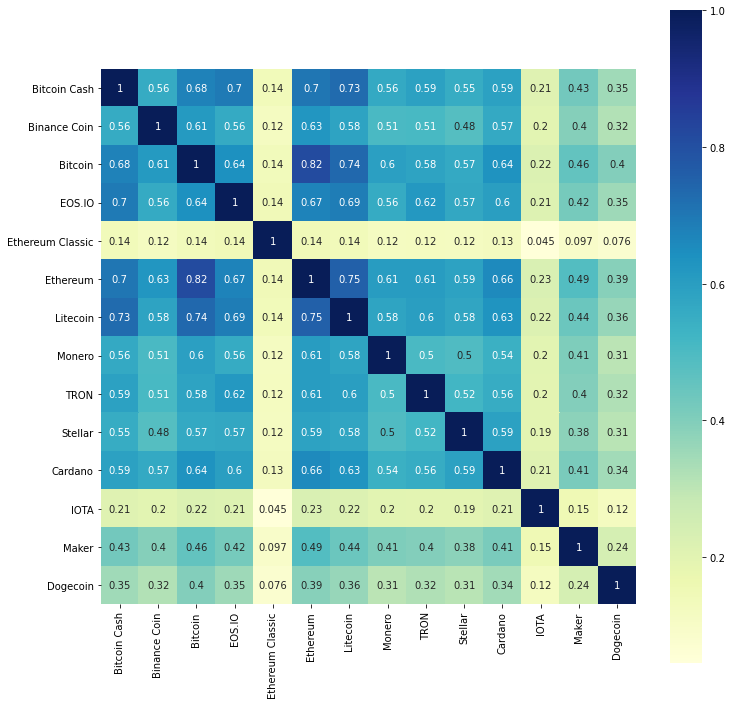

In [51]:
corrmat = criptos.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, cmap="YlGnBu",annot=True,square=True);

Se observa algunos pares de criptomonedas presentan mayor correlación que otras.

# **04. MODELO PREDICTIVO**




El objetivo del modelo es predecir los rendimientos en un futuro cercano para el precio de la criptomoneda. Cada fila del dataset contiene la variable "Target", la cual es el objetivo de la predicción. Esta variable surge calculando los retornos de cada criptomoneda en un intervalo de 15 minutos a futuro.

Según lo anterior, se puede observar que para cada criptomoneda los últimos 15 registros tienen un valor NaN en la variable Target. En este caso observamos esto para el Bitcoin

In [52]:
fecha_inicio_btc = datetime(2021, 7,20, 0, 0).timestamp()   
fecha_fin_btc = datetime(2021, 9,21, 0, 0).timestamp() - 901
bitcoin_part = bitcoin.loc[fecha_inicio_btc:fecha_fin_btc].fillna(0)
print()

In [53]:
bitcoin_part.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1626757200,1,1207.0,29663.790000,29699.000000,29637.04,29665.612857,96.943453,29656.240767,-0.000134
1626757260,1,1294.0,29669.554286,29732.000000,29655.60,29697.724286,84.855136,29682.653719,-0.000818
1626757320,1,2146.0,29701.708571,29772.000000,29683.90,29751.228571,154.656476,29718.267887,-0.000709
1626757380,1,1228.0,29746.324137,29773.062553,29695.55,29711.766175,44.131772,29724.039422,-0.002408
1626757440,1,980.0,29713.437143,29749.000000,29661.20,29720.514286,48.355971,29711.311458,-0.002000


In [54]:
bitcoin_part.shape

(90421, 9)

In [55]:
y_part = pd.DataFrame(bitcoin_part.Target)
y_part.head()

,Target
timestamp,
1626757200,-0.000134
1626757260,-0.000818
1626757320,-0.000709
1626757380,-0.002408
1626757440,-0.002000


In [56]:
bitcoin_part = bitcoin_part.drop(['Target'], axis = 1)
bitcoin_part.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,,
1626757200,1,1207.0,29663.790000,29699.000000,29637.04,29665.612857,96.943453,29656.240767
1626757260,1,1294.0,29669.554286,29732.000000,29655.60,29697.724286,84.855136,29682.653719
1626757320,1,2146.0,29701.708571,29772.000000,29683.90,29751.228571,154.656476,29718.267887
1626757380,1,1228.0,29746.324137,29773.062553,29695.55,29711.766175,44.131772,29724.039422
1626757440,1,980.0,29713.437143,29749.000000,29661.20,29720.514286,48.355971,29711.311458


In [57]:
#bitcoin_part['timestamp'] = bitcoin_part.index
(bitcoin['Target'] == 0).sum()

1

In [58]:
bitcoin['Target'].isnull().sum()

937

In [59]:
(y_part == 0).sum()/y_part.shape[0]

Target    0.000177
dtype: float64

In [60]:
y_part.isnull().sum()

Target    0
dtype: int64

## Extracción de características

In [61]:
# from tsfresh import extract_features, extract_relevant_features, select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
# from tsfresh.utilities.dataframe_functions import roll_time_series


In [62]:
# extraction_settings = ComprehensiveFCParameters()
# minimal_extraction_settings = MinimalFCParameters()

In [63]:
# df_rolled = roll_time_series(bitcoin_part, column_id="Asset_ID", max_timeshift=15, min_timeshift=1)

In [64]:
# df_rolled

In [65]:
# df_features = extract_features(df_rolled, column_id="id", column_sort="sort",
#                                 default_fc_parameters=minimal_extraction_settings
#                                 )

In [66]:
# df_features

In [67]:
# y_part = y_part.drop([1626757200],axis=0)

In [68]:
# a = y_part.to_numpy()
# a.flatten()

In [69]:
# X_filtered = select_features(df_features, y_part.to_numpy().flatten())

In [70]:
# X_filtered.head()

## Definición de conjuntos de entrenamiento y test para un primer modelo predictivo

In [71]:
fecha_inicio_train = datetime(2021, 7,20, 0, 0).timestamp()   #Se escogen los ultimos tres meses de registros para crear conjuntos de entrenamiento y test
fecha_fin_train = datetime(2021, 8,20, 23, 59).timestamp()  
fecha_inicio_test = datetime(2021, 8,21, 0, 0).timestamp()   
fecha_fin_test = datetime(2021, 9,21, 0, 0).timestamp() - 901  # Se resta este valor para no considerar los ultimos 15 minutos los cuales no tienen valores en "Target"

In [72]:
y = bitcoin.Target

X_train = bitcoin.loc[fecha_inicio_train:fecha_fin_train].fillna(0)
X_train = X_train.drop(['Target'], axis = 1).to_numpy() 
y_train = y.loc[fecha_inicio_train:fecha_fin_train].fillna(0).to_numpy()  

X_test = bitcoin.loc[fecha_inicio_test:fecha_fin_test].fillna(0)
X_test = X_test.drop(['Target'], axis = 1).to_numpy() 
y_test = y.loc[fecha_inicio_test:fecha_fin_test].fillna(0).to_numpy() 

In [101]:
fecha_train = datetime(2021, 8,20, 22, 0).timestamp()   
fecha_train2 = datetime(2021, 8,20, 22, 44).timestamp()  
fecha_test = datetime(2021, 8,20, 22, 45).timestamp()   
fecha_test2 = datetime(2021, 8,21, 0, 0).timestamp() - 901

y_train_new = bitcoin.loc[fecha_prueba:fecha_prueba2].fillna(0)
y_test_new = bitcoin.loc[fecha_test:fecha_test2].fillna(0)

In [104]:
bitcoin.iloc[int(fecha_prueba):]

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 14,8

#Labels and titles
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.title("3 fold cross-validation")

#First fold- CV
plt.plot(train1.index, train1, label='Train1')
plt.plot(test1.index, test1, label='Test1')
plt.plot(pred1.index, pred1, label='Holt-Winters prediction1')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test1.index[0], test1.index[-1],  facecolor='g', alpha=0.1)

#Second fold
plt.plot(train2.index, train2, label='Train2')
plt.plot(test2.index, test2, label='Test2')
plt.plot(pred2.index, pred2, label='Holt-Winters prediction2')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test2.index[0], test2.index[-1],  facecolor='r', alpha=0.2)

#Third fold
plt.plot(test3.index, test3, label='Test3')
plt.plot(pred3.index, pred3, label='Holt-Winters prediction3')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='b', alpha=0.3)

In [73]:
# ENTRENAR MODELO CON NUEVAS FEATURES Y COMPARAR CON ORIGINAL

## Escalamiento de los datos

In [74]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Construcción de modelos

In [75]:
cross_validation = TimeSeriesSplit(n_splits=5)

In [76]:
modelo_lr = LinearRegression()
cross_validation_result = cross_val_score(modelo_lr, X_train_scaled, y_train, cv=cross_validation, scoring='r2')
print('R2 Score: ', cross_validation_result.mean(),'   Desviación:  ', cross_validation_result.std())

R2 Score:  -0.014186750502882872    Desviación:   0.015079328116122902


In [77]:
modelo_rf = RandomForestRegressor(n_estimators = 10, random_state=0)
cross_validation_result = cross_val_score(modelo_rf, X_train_scaled, y_train, cv=cross_validation, scoring='r2')
print('R2 Score: ', cross_validation_result.mean(),'   Desviación:  ', cross_validation_result.std())

R2 Score:  -0.5414675530676363    Desviación:   0.42843848827830194


## Resultados

Ahora se evalua el modelo con los datos de test:

En la competencia de Kaggle la metrica de evaluación que utilizan es el coeficiente de correlación de Pearson. Se presetan los resultados obtenidos para estos dos modelos:

In [78]:
modelo_lr.fit(X_train_scaled, y_train)
y_pred1 = modelo_lr.predict(X_test_scaled)
Score_model = np.corrcoef(y_pred1, y_test)
print('Resultado (Linear Regression): ', Score_model[0,1])

Resultado (Linear Regression):  0.08682946781227582


In [79]:
modelo_rf.fit(X_train_scaled, y_train)
y_pred2 = modelo_rf.predict(X_test_scaled)
Score_model = np.corrcoef(y_test, y_pred2)
print('Resultado (Random Forest): ', Score_model[0,1])

Resultado (Random Forest):  0.009347854577366912


In [80]:
mean_absolute_percentage_error(y_test, y_pred1)

162395761.4543157

In [81]:
mean_squared_error(y_test, y_pred1)

1.6207882475988909e-06

In [87]:
# SMAPE proposed by Makridakis (1993): 0%-200%
import sktime
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

def smape_original(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)


# adjusted SMAPE version to scale metric from 0%-100%
def smape_adjusted(a, f):
    return 100*(1/a.size * np.sum(np.abs(f-a) / (np.abs(a) + np.abs(f))))

print(smape_adjusted(y_test, y_pred1))
print(smape_adjusted(y_test, y_pred2))


print(100*smape(y_test, y_pred1))
print(100*smape(y_test, y_pred2))

print(smape_original(y_test, y_pred1))
print(smape_original(y_test, y_pred2))

90.10244014678244
73.55281560808771
180.20488029356488
147.10563121617542
180.2048802935649
147.10563121617545


c:\Users\M.R.S\anaconda3\lib\site-packages\sktime\performance_metrics\forecasting\_functions.py:1543: FutureWarning:

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.

c:\Users\M.R.S\anaconda3\lib\site-packages\sktime\performance_metrics\forecasting\_functions.py:1543: FutureWarning:

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.



In [83]:
BIAS = y_pred2.sum()/y_test.sum()
BIAS

2.4319112050483107

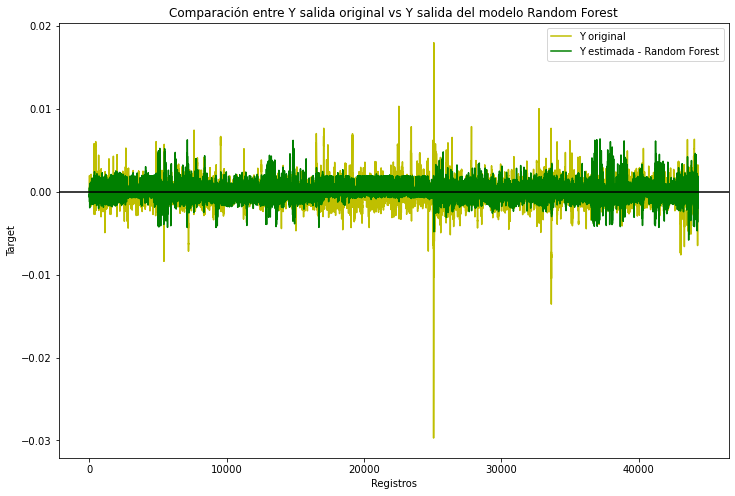

In [84]:
fig = plt.figure(figsize=(12,8))
line_1 = plt.plot(np.arange(len(y_test)), y_test, color = 'y', label='Y original') 
line_2 = plt.plot(np.arange(len(y_test)), y_pred2, color = 'g', label='Y estimada - Random Forest') 
plt.axhline(0, color="black") 
plt.legend()
plt.title('Comparación entre Y salida original vs Y salida del modelo Random Forest') # Titulo de la gráfica
plt.xlabel('Registros') 
plt.ylabel('Target') 
plt.show() 

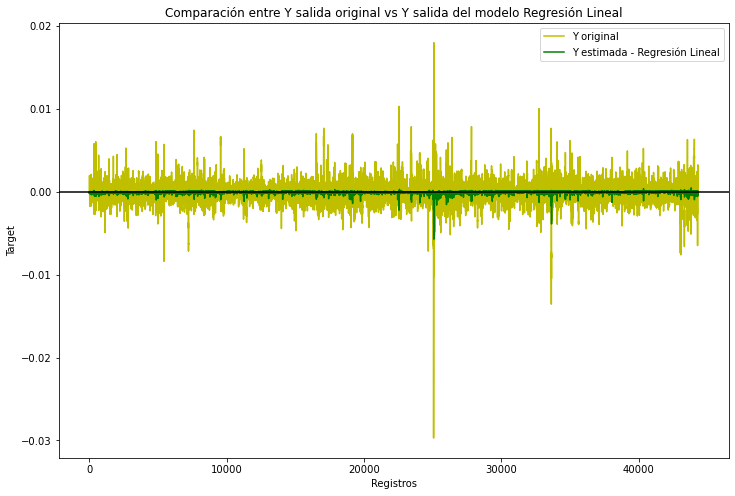

In [85]:
fig = plt.figure(figsize=(12,8))
line_1 = plt.plot(np.arange(len(y_test)), y_test, color = 'y', label='Y original') 
line_2 = plt.plot(np.arange(len(y_test)), y_pred1, color = 'g', label='Y estimada - Regresión Lineal') 
plt.axhline(0, color="black") 
plt.legend()
plt.title('Comparación entre Y salida original vs Y salida del modelo Regresión Lineal') # Titulo de la gráfica
plt.xlabel('Registros') 
plt.ylabel('Target') 
plt.show() 

## Conclusiones y posibles mejoras

- Un punto importante a tener en cuenta es que se está evaluando una moneda independientemente de las otras, pero como se vio anteriormente  las monedas pueden estar correlacionadas, una posible opción sería utilizar un modelo donde se puedan relacionar entre ellas.

- Se deben realizar las predicciones con otro tipo de modelos diseñados para tratar este tipo de problemas, las opciones podrían ser redes neronales recurrentes o modelos Autoregresivos.

- A partir de los datos que se tienen en el conjutno de datos se podrían diseñar algunas otras caracteristicas o variables que sean entradas al modelo para mejorar su rendimiento.